In [2]:
import pandas as pd
import spacy
from spacy.training import Example
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_excel("/Users/sakshi_admin/Feedback Analysis/Feedback Analysis.xlsx")

# Drop rows with null values in 'RequestText' or 'QuestionCategory'
data.dropna(subset=['RequestText', 'QuestionCategory'], inplace=True)

# Ensure all data in 'RequestText' is treated as string
data['RequestText'] = data['RequestText'].astype(str).str.lower().str.strip()

# Convert categories to string to ensure compatibility with SpaCy
data['QuestionCategory'] = data['QuestionCategory'].astype(str)

# Splitting the data into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Load SpaCy model
nlp = spacy.blank("en")

# Add text classifier to the pipeline with appropriate configuration
config = {
    "threshold": 0.5,
    "model": {
        "@architectures": "spacy.TextCatBOW.v2",
        "exclusive_classes": True,
        "ngram_size": 1,
        "no_output_layer": False
    }
}
textcat = nlp.add_pipe("textcat", config=config)

# Add labels to text classifier
for category in train_data['QuestionCategory'].unique():
    textcat.add_label(str(category))  # Ensure the label is a string

# Training the model
train_texts = train_data['RequestText'].values
train_labels = []
for cat in train_data['QuestionCategory']:
    cat_dict = {label: label == cat for label in textcat.labels}
    train_labels.append({'cats': cat_dict})

train_examples = [Example.from_dict(nlp.make_doc(text), cats) for text, cats in zip(train_texts, train_labels)]
optimizer = nlp.initialize()

for i in range(10):
    losses = {}
    random.shuffle(train_examples)
    for batch in spacy.util.minibatch(train_examples, size=8):
        nlp.update(batch, sgd=optimizer, losses=losses)
    print(f"Losses at iteration {i}: {losses}")

# Predicting on the test set
test_texts = test_data['RequestText'].values
test_cats = test_data['QuestionCategory'].values

predictions = []
for text in test_texts:
    doc = nlp(text)
    predictions.append(max(doc.cats, key=doc.cats.get))

# Evaluation metrics
accuracy = accuracy_score(test_cats, predictions)
precision, recall, f1, _ = precision_recall_fscore_support(test_cats, predictions, average='weighted')
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Print a classification report and confusion matrix
print("Classification Report:")
print(classification_report(test_cats, predictions))

# Generate a confusion matrix
cm = confusion_matrix(test_cats, predictions, labels=textcat.labels)
df_cm = pd.DataFrame(cm, index=textcat.labels, columns=textcat.labels)




Losses at iteration 0: {'textcat': 1.1031835561152548}
Losses at iteration 1: {'textcat': 0.8137403121218085}
Losses at iteration 2: {'textcat': 0.6901943310222123}
Losses at iteration 3: {'textcat': 0.6209085303999018}
Losses at iteration 4: {'textcat': 0.573048758727964}
Losses at iteration 5: {'textcat': 0.5376156749844085}
Losses at iteration 6: {'textcat': 0.5055830870987847}
Losses at iteration 7: {'textcat': 0.47826636717945803}
Losses at iteration 8: {'textcat': 0.45778749102464644}
Losses at iteration 9: {'textcat': 0.43864381356252125}
Accuracy: 0.6752411575562701
Precision: 0.5930028338794063
Recall: 0.6752411575562701
F1 Score: 0.626698093611272
Classification Report:
                                                                                                                                                                                                                                               precision    recall  f1-score   support

                               

/Users/sakshi_admin/Feedback Analysis/vnvv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sakshi_admin/Feedback Analysis/vnvv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sakshi_admin/Feedback Analysis/vnvv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

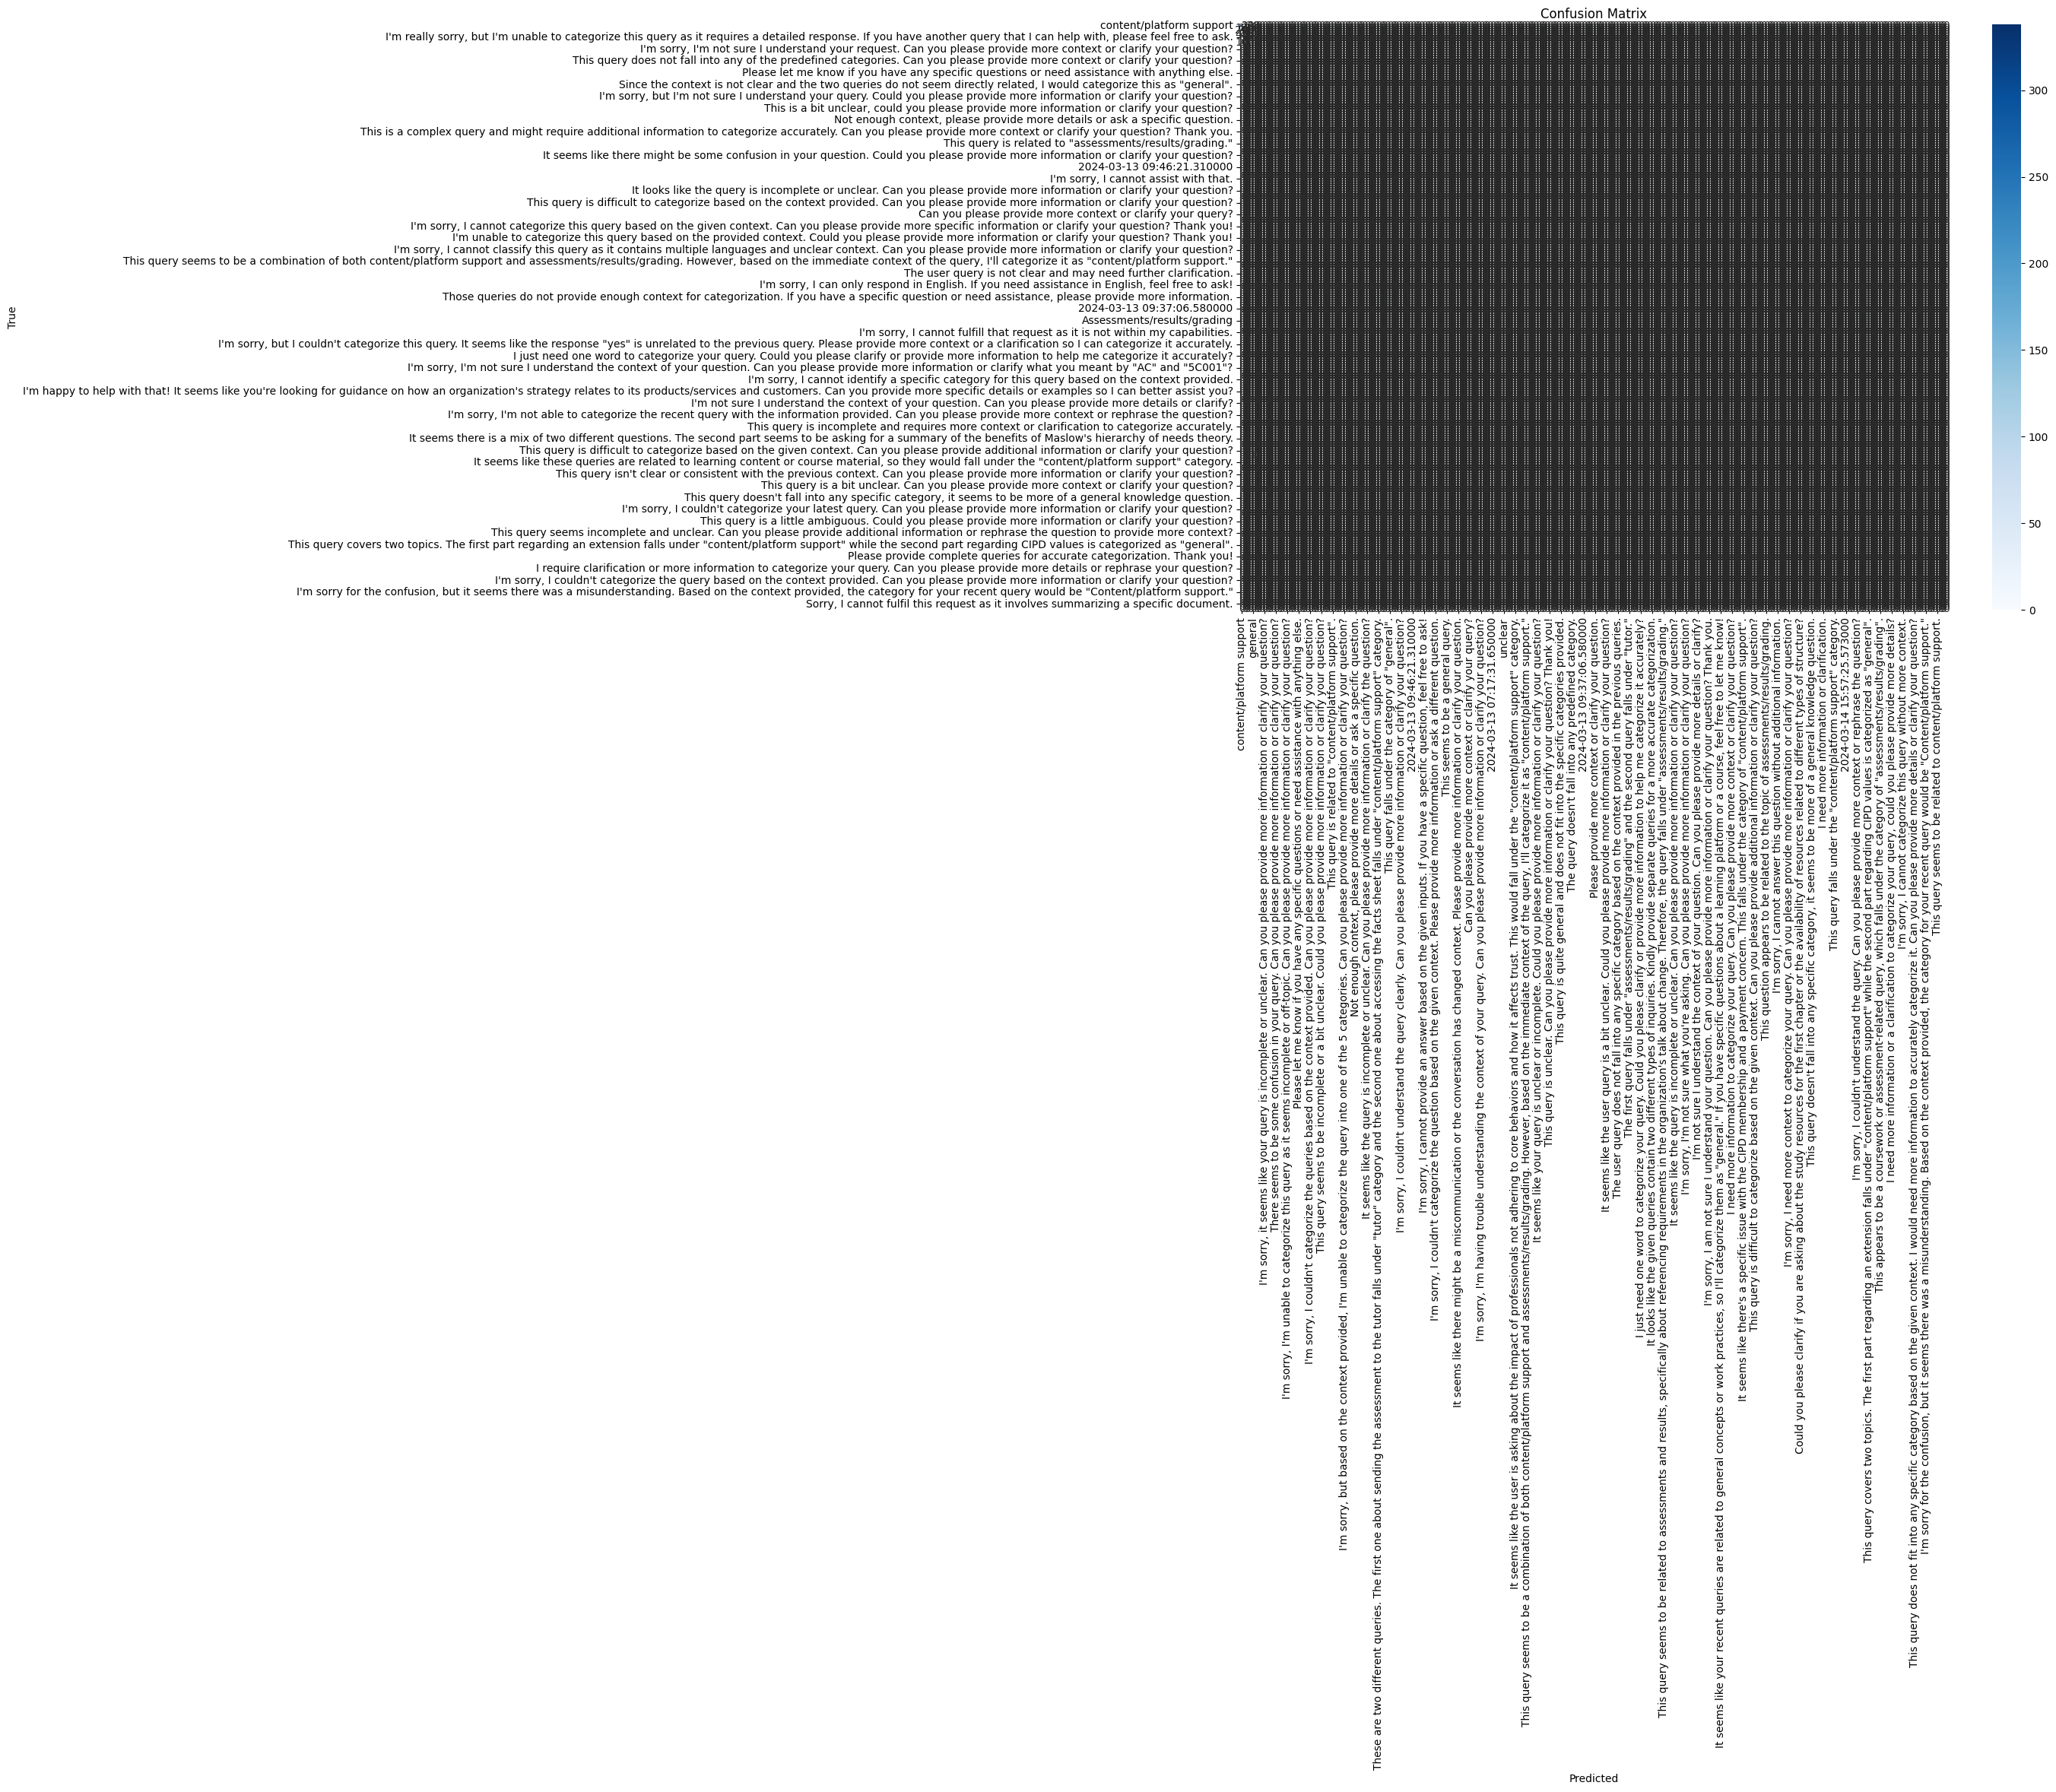

Text: can i submit early
Predicted category: content/platform support

Text: where can i find more on "analysis showing the connections between strategy, products or services, and customers"
Predicted category: content/platform support

Text: tell me the name on my tutor
Predicted category: tutor

Text: i do not understand what couse i need to attend and what is not
Predicted category: content/platform support

Text: where i can submit the assignment
Predicted category: content/platform support

Text: when?
Predicted category: content/platform support

Text: 5co02 can you see my submission?
Predicted category: content/platform support

Text: no it is not there
Predicted category: content/platform support

Text: how do i explain "unfreeze"?
Predicted category: content/platform support

Text: where is tutor update?
Predicted category: content/platform support



In [3]:
# Plotting the confusion matrix
plt.figure(figsize=(15,10))
sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Check a few random predictions
sample_test_texts = test_data['RequestText'].sample(10, random_state=45)
for text in sample_test_texts:
    doc = nlp(text)
    print(f"Text: {text}\nPredicted category: {max(doc.cats, key=doc.cats.get)}\n")